# Solar Decomposition Models

Direct or beam normal irradiance is often an useful variable in solar and energy applications, for example, in solar concetrating power projects. When the direct normal irradiance (DNI) is not directly measured by pyranometers on site, **solar radiation decomposition models** can assist us in estimating the direct beam radiation by applying an empirical correlations between global horizontal irradiance (GHI), diffuse horizontal irradiance (DHI) and DNI. In this section, we present the implementation in Python of several solar decomposition models. 

***
<div style="text-align: right"> <i>Content by Javier Lopez Lorente</i> </div>


## The role of solar decomposition models

Solar decomposition models are one of the most recurrent types of algorithms within solar radiation modelling and are sometimes used as part of a larger analysis. As described earlier, decomposition models permit estimating the beam or direct normal irradiance (DNI) from GHI measurements, through relationships of the clearness index ($k_t$) and the diffuse fraction of solar irradiance ($k_d$). The clearness index is defined as:

$$ k_t = \frac{GHI}{E_a \cdot cos(\theta_Z)}$$

where $E_a$ is the extraterrestrial irradiance, and $\theta_Z$ is the solar zenith angle. 

The diffuse fraction is defined as: 

$$ k_d = \frac{DHI}{GHI} $$

The role of decomposition models can be graphically illustrated in the diagram below:

```{image} ../notebooks/graphics/decomposition_models.png
:alt: decomposition_flowchart
:class: bg-white mb-1
:width: 500px
:align: center
```


Multiple models have been proposed for the decomposition of global horizontal radiation/irradiance into its direct normal and diffuse horizontal components in the academic literature. Below, the implementation in Python of some of these methods will be shown. The following methods will be modelled and compared:
- DISC model (Maxwell, 1987)
- DIRINT model (Pérez et al., 1992)
- Erbs model (Erbs et al., 1982) 

These 3 methods, and some others, are available in the Python library [pvlib](https://pvlib-python.readthedocs.io/en/stable/api.html#dni-estimation-models).

Before starting the modelling of these methods, the data that we will use will be queried and prepared.

## Data preparation

To illustrate the implementation of each of these models, we will use real irradiance observations. GHI measurements will be decomponsed into DNI and DHI, and the results will be then compared to actual measurements from DNI and DHI.

Yet, the first step is getting and preparing the real weather data to be used:

**Retrieving weather data:**

The weather data used is from a meteorological [station](https://midcdmz.nrel.gov/apps/sitehome.pl?site=UAT) located at the SOLRMAP University of Arizona (OASIS), which is part of the Measurement and Instrumentation Data Center (MIDC) of the U.S. National Renewable Energy Laboratory (NREL). The coordinates of the station are latitude 32.22969$^\circ$ and longitude -110.95534$^\circ$, and an elevation of 786 AMSL. The data used are 1-minute global, direct and diffuse irradiance measurements for July 2021 (Andreas and Wilcox, 2010).

In [1]:
# Import all the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pvlib

In [2]:
# Variables map to edit the names of certain variables
var_map = {'Global Horiz (platform) [W/m^2]': 'ghi',
           'Direct Normal [W/m^2]':'dni',
           'Diffuse Horiz [W/m^2]':'dhi',
           'Air Temperature [deg C]': 'tamb_degC', 
           'Rel Humidity [%]': 'RH',
           'Station Pressure [mBar]':'P_mbar'}

# Retrieving the raw data from the station 
df_ref = pvlib.iotools.read_midc_raw_data_from_nrel('UAT',                     # Station id
                                                    pd.Timestamp('20210701'),   # Start date YYYYMMDD
                                                    pd.Timestamp('20210731'),   # End date  YYYYMMDD
                                                    variable_map=var_map)       # Variable Map

# Let's have a look to the first 2 rows of the dataset
df_ref.head(2)

,Unnamed: 0,Year,DOY,MST,dni,dhi,Global Horiz (tracker) [W/m^2],ghi,Temp CHP1 [deg C],Temp CM22 (tracker) [deg C],Temp CM22 (platform) [deg C],CR1000 Temp [deg C],CR1000 Battery [VDC],tamb_degC,RH,P_mbar,Avg Wind Speed @ 3m [m/s],Avg Wind Direction @ 3m [deg from N],Peak Wind Speed @ 3m [m/s]
2021-07-01 00:00:00-07:00,0,2021,182,0,0.0,0.0,-1.85080,-2.05728,-246.8,-246.8,-246.8,28.27,13.27,26.36,54.01,925.057,2.471,334.4,5.45
2021-07-01 00:01:00-07:00,0,2021,182,1,0.0,0.0,-1.85081,-2.05729,-246.8,-246.8,-246.8,28.26,13.27,26.35,53.93,925.077,3.172,335.3,5.45


Besides GHI, DNI and DHI, this station has additional weather-related variables available (e.g., air temperature, humidity, and wind speed), as well as sensor-specific data. The details of the sensors and measurements available in each station can be found under the section "Instrument history and meta data" of each MIDC's station webpage. 

Let's list the variables available and then subset those that we will use in this example:

In [3]:
# Visualize variables avilable
df_ref.columns

Index(['Unnamed: 0', 'Year', 'DOY', 'MST', 'dni', 'dhi',
       'Global Horiz (tracker) [W/m^2]', 'ghi', 'Temp CHP1 [deg C]',
       'Temp CM22 (tracker) [deg C]', 'Temp CM22 (platform) [deg C]',
       'CR1000 Temp [deg C]', 'CR1000 Battery [VDC]', 'tamb_degC', 'RH',
       'P_mbar', 'Avg Wind Speed @ 3m [m/s]',
       'Avg Wind Direction @ 3m [deg from N]', 'Peak Wind Speed @ 3m [m/s]'],
      dtype='object')

In [4]:
# Dataframe with the variables used in the example
decomp = df_ref[['ghi','dni','dhi', 'tamb_degC', 'RH', 'P_mbar']]

Let's have a look to the statistical description of the data:

In [5]:
decomp.describe()

,ghi,dni,dhi,tamb_degC,RH,P_mbar
count,44640.000000,44640.000000,44640.000000,44640.000000,44640.000000,44640.000000
mean,270.016692,244.196683,93.612505,29.588765,49.146020,925.919327
std,352.199196,344.676616,123.876749,5.181255,20.025314,1.793095
min,-7.540170,-5.782160,-0.721871,19.670000,10.780000,920.315000
25%,-2.057020,-0.130126,0.000000,25.630000,31.720000,924.885000
50%,45.498000,0.238494,41.863400,28.640000,49.640000,925.900000
75%,536.188000,588.421000,139.650000,33.600000,64.250000,927.132000
max,1502.680000,927.270000,711.501000,42.650000,100.000000,931.300000


The statistical description of the data gives us an idea of the range of the data. We can also visualize one or several days to see the measurements of GHI, DHI and DNI. For example, a plot for a single day (8th July 2021):

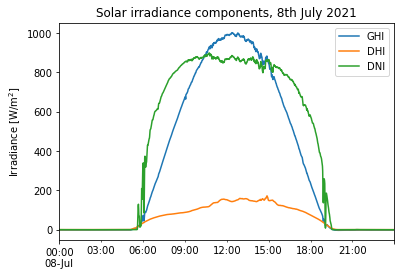

In [6]:
# list variables to plot
all_series = ['ghi', 'dhi', 'dni']

# Plot by iterating a the loop using the 'pandas.DataFrame.plot()' method. 
for series in all_series:
    decomp.loc['20210708'][series].plot(label=series.upper()) # Date format YYYYMMDD
plt.title('Solar irradiance components, 8th July 2021')
plt.ylabel('Irradiance [W/m$^2$]')
plt.legend()

**Estimating other input variables:**

The 3 solar decomposition models that we will implement in this section (i.e., DISC, DIRINT and Erbs models) have different inputs to be implemented. **Solar position data** is a common input for the 3 models. The DISC and DIRINT models accept as a possible input the **dew (wet-bulb) temperature** ($T_d$). This variable is not directly available from our weather observations; however, it can be easily estimated using a simple conversion that has relative humidity ($RH$) and the ambient temperature ($T_a$) as input. This simple approximation is given by the equation below (Lawrence, 2005):

 $$ T_{d} = T_a (^{\circ} C) - \frac{100-RH (\%)}{5} $$
 
In Python, this equation could be implemented as follows:

In [7]:
tdew = decomp['tamb_degC']-((100-decomp['RH'])/5)

Variables related to solar position can be estimated in straight-forward manner with the method 'pvlib.solarposition.get_solarposition' of pvlib.

In [8]:
# Coordinates and elevation of the weather station SOLRMAP University of Arizona (OASIS)
lat = 32.22969
lon = -110.95534
alt = 786

# Estimate Solar Position
solpos = pvlib.solarposition.get_solarposition(time=decomp.index,
                                               latitude=lat,
                                               longitude=lon,
                                               altitude=alt,
                                               temperature=decomp['tamb_degC'],
                                               pressure=decomp['P_mbar']*100) # pressure in Pascal (1 mbar = 100 Pa)

# Let's have a look to the output
solpos.head(5)

,apparent_zenith,zenith,apparent_elevation,elevation,azimuth,equation_of_time
2021-07-01 00:00:00-07:00,124.293142,124.293142,-34.293142,-34.293142,352.285310,-3.873236
2021-07-01 00:01:00-07:00,124.321069,124.321069,-34.321069,-34.321069,352.561624,-3.873369
2021-07-01 00:02:00-07:00,124.347985,124.347985,-34.347985,-34.347985,352.838177,-3.873502
2021-07-01 00:03:00-07:00,124.373887,124.373887,-34.373887,-34.373887,353.114958,-3.873636
2021-07-01 00:04:00-07:00,124.398775,124.398775,-34.398775,-34.398775,353.391959,-3.873769


## DISC model

The DISC model (Maxwell, 1987) can be implemented in Python by passing as inputs the GHI, solar zenith angle and the atmospheric pressure, which is used to estimate the absolute (pressure-corrected) airmass. The method can be equally applied with the relative airmass by passing *'None'* to the pressure.

In [9]:
# DISC method estimated with absolute airmass as input
disc = pvlib.irradiance.disc(decomp['ghi'], 
                             solpos['apparent_zenith'], 
                             decomp.index,
                             pressure=decomp['P_mbar']*100) # Pressure in Pascal 

The method returns the DNI, the clearness index ($k_t$) and the airmass estimation:

In [10]:
disc.columns

Index(['dni', 'kt', 'airmass'], dtype='object')

## DIRINT model

The DIRINT model (Pérez et al., 1992) can be implemented in a similar way in Python. The inputs for the built-in pvlib function are GHI, solar zenith angle, atmospheric pressure, and dew (wet-bulb) temperature. 

In [11]:
# Estimation of the DIRINT model
dirint = pvlib.irradiance.dirint(decomp['ghi'], # GHI
                                 solpos['apparent_zenith'], # Solar zenith angle 
                                 decomp.index,  # timestamps
                                 pressure=decomp['P_mbar']*100, # atmospheric pressure in Pascal 
                                 temp_dew=tdew) # Dew temperature in Degree Celsius


## Erbs model

The Erbs model (Erbs et al., 1982) is a simple model that only requires GHI and the solar position through the solar zenith angle. This model is also available in pvlib and the implementation is equally straight-forward:

In [12]:
erbs = pvlib.irradiance.erbs(decomp['ghi'], # GHI
                             solpos['apparent_zenith'], # Solar zenith angle 
                             decomp.index)  # timestamps

erbs.columns

Index(['dni', 'dhi', 'kt'], dtype='object')

## Comparison and evaluation of decomposition models

Once the 3 models are estimated, we can evaluate the results of the models against the actual DNI measurements available. For example, below we visualize the results of the models a single day and 1 week in July:


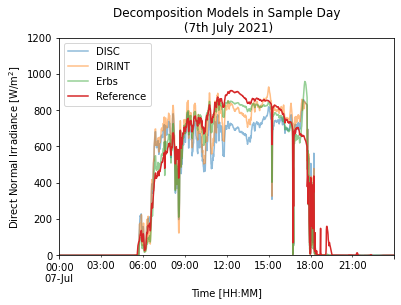

In [13]:
# Plot of models for a single day
disc.loc['20210707']['dni'].plot(label='DISC', alpha=0.5) # format of date YYYYMMDD
dirint.loc['20210707'].plot(label='DIRINT', alpha=0.5)
erbs.loc['20210707']['dni'].plot(label='Erbs', alpha=0.5)
decomp.loc['20210707']['dni'].plot(label='Reference')
plt.ylim(0,1200)
plt.ylabel('Direct Normal Irradiance [W/m$^2$]')
plt.xlabel('Time [HH:MM]')
plt.title('Decomposition Models in Sample Day\n (7th July 2021)')
plt.legend(loc='upper left')

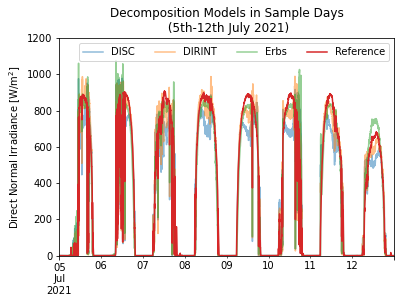

In [14]:
# Plot of models for several days
disc.loc['20210705':'20210712']['dni'].plot(label='DISC', alpha=0.5) # format of date YYYYMMDD
dirint.loc['20210705':'20210712'].plot(label='DIRINT', alpha=0.5)
erbs.loc['20210705':'20210712']['dni'].plot(label='Erbs', alpha=0.5)
decomp.loc['20210705':'20210712']['dni'].plot(label='Reference')
plt.ylim(0,1200)
plt.ylabel('Direct Normal Irradiance [W/m$^2$]')
plt.title('Decomposition Models in Sample Days\n (5th-12th July 2021)')
plt.legend(ncol=4)

The correlation between the obtained models and the measured observations can be also presented in **scatter plots**:

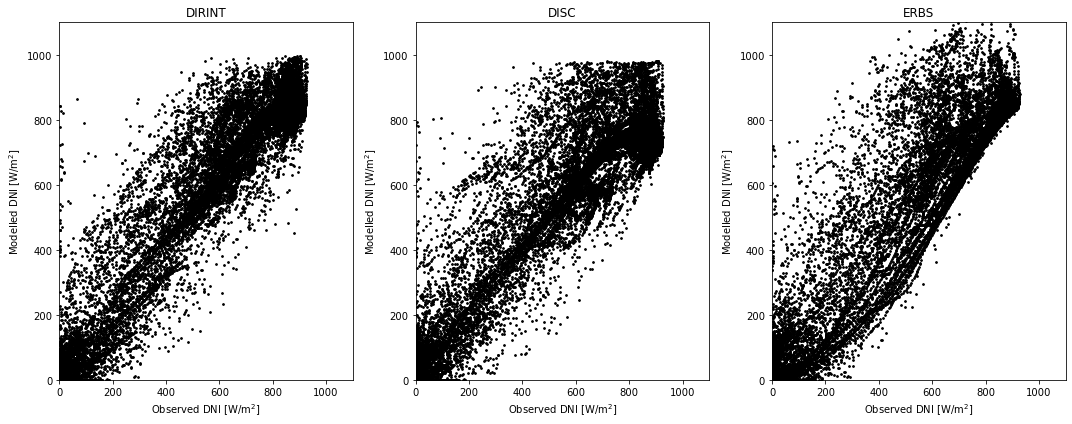

In [15]:
# Create multiple plots
fig, axs = plt.subplots(1,3, figsize=(15, 6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)

# Wrap the axes
axs = axs.ravel()

# Plot
axs[0].scatter(decomp['dni'], dirint, s=3, c='k')
axs[1].scatter(decomp['dni'], disc['dni'], s=3, c='k') 
axs[2].scatter(decomp['dni'], erbs['dni'], s=3, c='k')

# Add characteristics to each subplot in a loop
plots = ['DIRINT', 'DISC', 'ERBS']
for i in range(3):
    axs[i].set_xlabel('Observed DNI [W/m$^2$]')
    axs[i].set_ylabel('Modelled DNI [W/m$^2$]')
    axs[i].set_xlim(0, 1100)
    axs[i].set_ylim(0, 1100)
    axs[i].set_title(plots[i])

plt.tight_layout()
plt.show()

The evaluation cannot be only based on a visual inspection. For solar resource assessment, there are a number of common metrics to evaluate the error and performance, which we will use below. These metrics are the mean bias error (MBE) and the root mean square error (RMSE). The MBE is the average error representing a systematic error to under- or overestimate and the RMSE is a measure of the dispersion of the deviations.

$$ MBE = \frac{1}{n} \sum_{i=1}^{n} M_i - O_i $$

$$ RMSE = \sqrt{\frac{1}{n}\sum_{i=1}^{n}{(M_i - O_i)^2}}$$

where $n$ is the size of the sample or dataset, $M_i$ is each of the predicted values and $O_i$ are the observed or true values. In Python, each of these evaluation metrics can be defined as function.


In [16]:
# Mean Bias Error
def mbe(predictions, observed):
    return (predictions - observed).mean()

# Root Mean Square Error 
def rmse(predictions, observed):
    return np.sqrt(((predictions - observed)**2).mean())

The performance metrics for DNI estimations can be obtained using these functions. 

For the DISC method:

In [17]:
mbe_disc = mbe(disc['dni'], decomp['dni'])
rmse_disc = rmse(disc['dni'], decomp['dni'])

print("DISC Decomposition Method:")
print("MBE " + "%.2f" % mbe_disc + " W/m\u00b2")
print("RMSE " + "%.2f" % rmse_disc + " W/m\u00b2")

DISC Decomposition Method:
MBE -3.14 W/m²
RMSE 89.20 W/m²


For the DIRINT method:

In [18]:
mbe_dirint = mbe(dirint, decomp['dni'])
rmse_dirint = rmse(dirint, decomp['dni'])

print("DIRINT Decomposition Method:")
print("MBE " + "%.2f" % mbe_dirint + " W/m\u00b2")
print("RMSE " + "%.2f" % rmse_dirint + " W/m\u00b2")

DIRINT Decomposition Method:
MBE 19.11 W/m²
RMSE 92.48 W/m²


For the Erbs method:

In [19]:
mbe_erbs = mbe(erbs['dni'], decomp['dni'])
rmse_erbs = rmse(erbs['dni'], decomp['dni'])

print("Erbs Decomposition Method:")
print("MBE " + "%.2f" % mbe_erbs + " W/m\u00b2")
print("RMSE " + "%.2f" % rmse_erbs + " W/m\u00b2")

Erbs Decomposition Method:
MBE 7.15 W/m²
RMSE 80.76 W/m²


The performance metrics show that, in this example, the Erbs method reports the lowest error metrics, closely followed by the DISC and the DIRINT methods, respectively.

## Section summary

This section has presented the solar radiation decomposition methods, which are a common type of technique to estimate the direct normal or beam irradiance from global horizontal irradiance observations. Particularly, the following examples have been covered: <br>
- The Python implementation of three solar radiation decomposition methods have been presented using real data, namely the models used are the DISC, DIRINT and Erbs models. <br>
- Time-series visualization and scatter plots have been introduced to evaluate differences in the models. <br>
- Two common error metrics to evaluate the performance, i.e. MBE and RMSE, have been introduced. <br>

Within solar resource assessment, decomposition methods are used as means to estimate the direct irradiance or irradiation for further analysis in particular applications. For example, in solar concentrating power where direct irradiance is essential for power generation availability. There are multiple decomposition methods available in the literature. However, the Python functions for these 3 methods are available in the Python library *pvlib*.

***

## References

Andreas, A., and Wilcox, S., (2010). 'Observed atmospheric and solar information system (OASIS)', Tucson, Arizona (Data), NREL Report No. DA-5500-56494. http://dx.doi.org/10.5439/1052226

Erbs, D. G., Klein, S. A., and Duffie, J. A., (1982). 'Estimation of the diffuse radiation fraction for hourly, daily and monthly-average global radiation', Solar Energy 28(4), pp 293-302.

Lawrence, M. G. (2005). 'The relationship between relative humidity and the dewpoint temperature in moist air: A simple conversion and applications', Bulletin of the American Meteorological Society, 86(2), pp. 225-234. https://doi.org/10.1175/BAMS-86-2-225

Maxwell, E. L., (1987). 'A quasi-physical model for converting hourly global horizontal to direct normal insolation', Technical Report No. SERI/TR-215-3087, Golden, CO: Solar Energy Research Institute.

Perez, R., Ineichen, P., Maxwell, E.,  Seals, R., and Zelenka, A., (1992). 'Dynamic global-to-direct irradiance conversion models'. ASHRAE Transactions-Research Series, pp. 354-369